In [1]:
import sys
import numpy as np
import time
#!python -m pip install ujson
import ujson as json

%matplotlib inline
import random
import pandas as pd
from matplotlib import pyplot as plt 

import itertools
import re

In [ ]:
import os
os.chdir('/xdisk/msurdeanu/fanluo/hotpotQA/') 
from util import get_buckets

In [2]:
import string
def normalize_answer(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punc(lower(s))))

import re
import string
# def findWholeWord(w):
#     return re.compile(r'\b({0})\b'.format(re.escape(w.strip(string.punctuation))), flags=re.IGNORECASE).search
#     # strip(string.punctuation) to remove heading and ending punctuations in the answer, otherwise can not found correctly if heading or ending punctuations appears
    
def findWord(w, context):
    if(w == ''):
        return False
    if(len(list(re.finditer(str(w), str(context), re.IGNORECASE))) > 0):
        return True
    else:
        return False

## HopotQA dataset

### Train Statistics

In [3]:
with open('/xdisk/msurdeanu/fanluo/hotpotQA/hotpot_train_v1.1.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data)) 
train_question_df = pd.DataFrame(data[0])
del data
import gc
gc.collect()

0

In [4]:
pd.set_option('display.max_colwidth', None)    # display full (non-truncated) column
pd.set_option('display.max_columns', None)   # show all columns
train_question_df.head(3)

supporting_facts  \
0                                       [[Arthur's Magazine, 0], [First for Women, 0]]   
1                                          [[Oberoi family, 0], [The Oberoi Group, 0]]   
2  [[Allie Goertz, 0], [Allie Goertz, 1], [Allie Goertz, 2], [Milhouse Van Houten, 0]]   

    level  \
0  medium   
1  medium   
2    hard   

                                                                                                                          question  \
0                                                           Which magazine was started first Arthur's Magazine or First for Women?   
1                                                The Oberoi family is part of a hotel company that has a head office in what city?   
2  Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [5]:
train_question_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90447 entries, 0 to 90446
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   supporting_facts  90447 non-null  object
 1   level             90447 non-null  object
 2   question          90447 non-null  object
 3   context           90447 non-null  object
 4   answer            90447 non-null  object
 5   _id               90447 non-null  object
 6   type              90447 non-null  object
dtypes: object(7)
memory usage: 4.8+ MB


#### level

In [6]:
# Distribution of difficulty levels
grouped = train_question_df.groupby(['level'])
level_counts = grouped.size()  # count of each 
level_counts

level
easy      17972
hard      15661
medium    56814
dtype: int64

#### type

In [7]:
train_question_df.type.describe()

count      90447
unique         2
top       bridge
freq       72991
Name: type, dtype: object

In [8]:
# Distribution of type
grouped = train_question_df.groupby(['type'])
type_counts = grouped.size()  # count of each 
type_counts

type
bridge        72991
comparison    17456
dtype: int64

#### context 

In [9]:
train_question_df['context_flattened'] = train_question_df['context'].map(lambda x: list(itertools.chain.from_iterable(itertools.chain(para[1] for para in x))))

In [10]:
train_question_df['context_joint'] = train_question_df['context_flattened'].map(lambda x: " ".join(x) )

In [11]:
train_question_df.context_joint  = train_question_df.context_joint.map(normalize_answer)  
# train_question_df.context_joint  = train_question_df.context_joint.str.lower().map(lambda x:  " ".join(re.sub(r'"', r'', x).split()) ) 

In [12]:
train_question_df.head(1)

supporting_facts   level  \
0  [[Arthur's Magazine, 0], [First for Women, 0]]  medium   

                                                                 question  \
0  Which magazine was started first Arthur's Magazine or First for Women?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [13]:
train_question_df.context_flattened.str.len().describe()  # statistic of number of context sentences

count    90447.000000
mean        40.944907
std         11.207428
min          2.000000
25%         34.000000
50%         40.000000
75%         47.000000
max        144.000000
Name: context_flattened, dtype: float64

In [14]:
grouped = train_question_df.groupby(train_question_df.context_flattened.str.len())
num_of_context_sentences = grouped.size()  # count of each 
num_of_context_sentences

context_flattened
2       8
3      36
4      51
5      52
6      57
       ..
133     2
134     1
136     4
142     1
144     2
Length: 134, dtype: int64

In [15]:
num_of_context_sentences.max()

3788

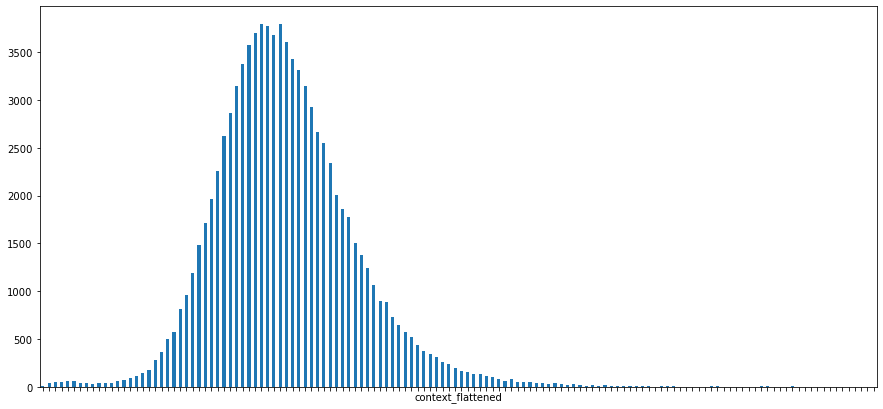

In [16]:
# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally
plt.setp(plot.axes.get_xticklabels(), visible=False)      # hide all labels
plt.setp(plot.axes.get_xticklabels()[::5], visible=True)  # set every 5 labels visible
plt.show() 

#### answer

In [17]:
train_question_df.answer = train_question_df.answer.map(normalize_answer)  # apply normalize_answer(answer)  

In [18]:
train_question_df.answer.str.split(' ').str.len().describe()  # statistic of number of words in the answer

count    90447.000000
mean         2.144328
std          1.641551
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         76.000000
Name: answer, dtype: float64

In [19]:
grouped = train_question_df.groupby(train_question_df.answer.str.split(' ').str.len())
num_of_answer_words = grouped.size()  
num_of_answer_words

answer
1     32984
2     32024
3     16665
4      4980
5      2003
6       663
7       328
8       159
9       112
10       85
11       70
12       42
13       45
14       42
15       30
16       34
17       23
18       27
19       18
20       17
21       11
22       14
23       12
24       11
25       12
26        5
27        4
28        3
29        3
30        5
31        2
32        3
33        3
34        1
35        2
38        1
40        1
57        1
72        1
76        1
dtype: int64

In [20]:
# number of questions with answer 'yes'
train_question_df.loc[train_question_df['answer'] == 'yes'].shape[0]

2748

In [21]:
# number of comparison questions with answer 'yes'
train_question_df.loc[(train_question_df['answer'] == 'yes') & (train_question_df['type'] == 'comparison')].shape[0]

2748

In [22]:
# number of questions with answer 'no'
train_question_df.loc[train_question_df['answer'] == 'no'].shape[0]

2735

In [23]:
# number of comparison questions with answer 'no'
train_question_df.loc[(train_question_df['answer'] == 'no') & (train_question_df['type'] == 'comparison')].shape[0]

2735

questions with answer yes/no are all comparison questions, and (17456-2735-2748) = 68.6% comparison questions have span answers 

In [24]:
# train_question_df["normalized_answer_in_context"] = train_question_df.apply(lambda row: row['answer'] in row['context_joint'], axis=1)

In [25]:
train_question_df['normalized_answer_in_context'] = train_question_df.apply(lambda row:  findWord(row['answer'], row['context_joint']) == True , axis = 1)

In [26]:
train_question_df.normalized_answer_in_context.describe()

count     90447
unique        2
top        True
freq      87836
Name: normalized_answer_in_context, dtype: object

87836 questions' answer in the context, 90447-87836 = 2611 questions' answer are not in the context

In [27]:
train_question_df.loc[(train_question_df['normalized_answer_in_context'] == False) & (train_question_df['answer'] != 'yes') & (train_question_df['answer'] != 'no')  & (train_question_df['answer'] != '')]

supporting_facts level  \
38543  [[3OH!3, 0], [3OH!3, 1], [Regina Spektor, 0]]  hard   

                                                               question  \
38543  Which musician or group is from the US, 3OH!3 or Regina Spektor?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [28]:
train_question_df.loc[(train_question_df['normalized_answer_in_context'] == False)].answer.describe()

count     2611
unique       4
top        yes
freq      2586
Name: answer, dtype: object

For those answers are not in the context, most normalized_answer are 'yes', some are 'no' and '', only one exception is train_question_df.iloc[38543]   

In [29]:
train_question_df.iloc[38543].answer

'3oh3'

In [30]:
train_question_df.iloc[38543].context_joint

'regina ilyinichna spektor russian реги́нa ильи́нична спе́ктор born february 18 1980 is russianborn american singersongwriter and pianist she was born in moscow former soviet union now russia and began classical training on piano at age of six when she was nine years old her family emigrated from soviet union to united states where she continued her classical training into her teenage years she began to write original songs shortly thereafter 3oh 3 pronounced three oh three is american electronic music duo from boulder colorado made up of sean foreman and nathaniel motte they are best known for their single dont trust me from their album want which reached number seven on billboard hot 100 their second single remix of starstrukk featuring katy perry from want was top ten hit in united kingdom ireland finland poland and australia they gained further recognition by featuring kesha on song my first kiss which was made lead single from their album streets of gold album later peaked at numb

#### supporting facts

In [31]:
train_question_df['invalid_supporting_facts_ids'] = train_question_df.apply(lambda row: True in [sp_idx >= len(dict(row['context'])[sp_t]) for (sp_t, sp_idx) in row['supporting_facts']], axis = 1)

In [32]:
train_question_df['invalid_supporting_facts_ids'].describe()

count     90447
unique        2
top       False
freq      90425
Name: invalid_supporting_facts_ids, dtype: object

22 questions have at least a supporting fact id out of range. That is, supporting fact id >= total num of sentence in the paragraph

In [33]:
train_question_df.loc[train_question_df['invalid_supporting_facts_ids']==True]

supporting_facts  \
514                             [[Pro Wrestling Fujiwara Gumi, 0], [Pro Wrestling Fujiwara Gumi, 1], [Minoru Suzuki, 0], [Minoru Suzuki, 1], [Minoru Suzuki, 2]]   
8332                                                                             [[The Lion King, 0], [Jonathan Taylor Thomas, 1], [Jonathan Taylor Thomas, 20]]   
9548                                                                                [[Suite française (Poulenc), 0], [Francis Poulenc, 0], [Francis Poulenc, 3]]   
13415                                                                [[Guillermo del Toro, 1], [Pan's Labyrinth, 0], [Pan's Labyrinth, 1], [Pan's Labyrinth, 2]]   
20594           [[Harry Potter and the Chamber of Secrets (film), 0], [Harry Potter and the Chamber of Secrets (film), 6], [Rupert Grint, 1], [Rupert Grint, 4]]   
22896                                                         [[Division of Adelaide, 1], [Walkerville, South Australia, 0], [Walkerville, South Australia, 52]]   
27436                                                                                                     [[Ron Shelton, 0], [Khady Sylla, 0], [Khady Sylla, 2]]   
37004                                                                       [[Teenage Mutant Ninja Turtles (1990 film), 2], [Robbie Rist, 0], [Robbie Rist, 52]]   
38579                                                              [[Gaz Coombes, 0], [Gaz Coombes, 2], [Harry Styles, 0], [Harry Styles, 3], [Harry Styles, 4]]   
41267                                                                                   [[Samuel P. Cox, 0], [William T. Anderson, 1], [William T. Anderson, 2]]   
45705                                                   [[Elementary School Musical (South Park), 0], [South Park (season 12), 3], [South Park (season 12), 20]]   
49355                                                        [[Altona Christian Community, 0], [Altona Christian Community, 2], [Hutterite, 1], [Hutterite, 40]]   
50651                                                                    [[Plaza Towers Elementary School, 0], [2013 Moore tornado, 0], [2013 Moore tornado, 2]]   
52080                                                           [[Exotic felines as pets, 0], [Exotic felines as pets, 1], [Savannah cat, 0], [Savannah cat, 2]]   
60885  [[George William Featherstonhaugh, 1], [George William Featherstonhaugh, 2], [Albany and Schenectady Railroad, 1], [Albany and Schenectady Railroad, 30]]   
67475                                                                   [[Bentley compounds, 1], [Bentley compounds, 2], [Buprenorphine, 0], [Buprenorphine, 7]]   
77109                                                             [[Jiminy Glick in Lalawood, 0], [Jiminy Glick in Lalawood, 1], [Jan Hooks, 0], [Jan Hooks, 8]]   
85934                                                                                              [[Carlos Davis, 1], [Drop Dead Fred, 0], [Drop Dead Fred, 2]]   
86118                  [[1989 Valvettiturai massacre, 0], [1989 Valvettiturai massacre, 6], [Minister of Defence (India), 0], [Minister of Defence (India), 11]]   
86193                                   [[Rochester College, 0], [Rochester Hills, Michigan, 0], [Rochester Hills, Michigan, 1], [Rochester Hills, Michigan, 2]]   
88641                                               [[Ahtyba Rubin, 0], [Ahtyba Rubin, 2], [Iowa State Cyclones football, 0], [Iowa State Cyclones football, 4]]   
89961                                                                      [[Venus (film), 0], [Jodie Whittaker, 0], [Jodie Whittaker, 2], [Jodie Whittaker, 3]]   

        level  \
514    medium   
8332     easy   
9548   medium   
13415  medium   
20594  medium   
22896  medium   
27436    easy   
37004  medium   
38579    easy   
41267    hard   
45705  medium   
49355  medium   
50651  medium   
52080    hard   
60885    hard   
67475    hard   
77109  medium   
85934  medium   
86118  medium   
86193  medium   
88641    easy 

In [34]:
print(train_question_df.iloc[514].context[7])
len(train_question_df.iloc[514].context[7])

['Minoru Suzuki', ['Minoru Suzuki (鈴木 実 , Suzuki Minoru , ring name: 鈴木 みのる) (born June 17, 1968) is a Japanese professional wrestler and mixed martial artist who is currently working for New Japan Pro Wrestling (NJPW) as a freelancer.', ' He is the current NEVER Openweight Champion in his first reign.']]


2

In [35]:
train_question_df['supporting_fact_text'] = train_question_df.apply(lambda row: [normalize_answer(dict(row['context'])[sp_t][sp_idx]) for (sp_t, sp_idx) in row['supporting_facts'] if(sp_idx < len(dict(row['context'])[sp_t])) ], axis = 1)

# train_question_df['supporting_fact_text'] = train_question_df.apply(lambda row: ['<t> ' + normalize_answer(sp_t) + ' </t> ' + normalize_answer(dict(row['context'])[sp_t][sp_idx]) + ' [/sent]' for (sp_t, sp_idx) in row['supporting_facts'] if(sp_idx < len(dict(row['context'])[sp_t])) ], axis = 1)

In [36]:
train_question_df.head(3)

supporting_facts  \
0                                       [[Arthur's Magazine, 0], [First for Women, 0]]   
1                                          [[Oberoi family, 0], [The Oberoi Group, 0]]   
2  [[Allie Goertz, 0], [Allie Goertz, 1], [Allie Goertz, 2], [Milhouse Van Houten, 0]]   

    level  \
0  medium   
1  medium   
2    hard   

                                                                                                                          question  \
0                                                           Which magazine was started first Arthur's Magazine or First for Women?   
1                                                The Oberoi family is part of a hotel company that has a head office in what city?   
2  Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [37]:
# add a column to count the number of supporting facts
train_question_df['num_of_supporting_facts'] = train_question_df.supporting_fact_text.str.len()

In [38]:
# Distribution of number of supporting facts
train_question_df.num_of_supporting_facts.describe()

count    90447.000000
mean         2.384402
std          0.672601
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         12.000000
Name: num_of_supporting_facts, dtype: float64

In [39]:
# Distribution of number of supporting facts
grouped = train_question_df.groupby(['num_of_supporting_facts'])
num_of_supporting_facts_counts = grouped.size()  # count of each 
num_of_supporting_facts_counts

num_of_supporting_facts
2     63685
3     20019
4      5805
5       722
6       141
7        52
8        17
9         4
11        1
12        1
dtype: int64

In [40]:
# check thoese questions with more than 8 supportiing facts
train_question_df.loc[train_question_df.num_of_supporting_facts > 8]

supporting_facts  \
1722                                                                   [[Kazuo Ishiguro, 0], [Kazuo Ishiguro, 1], [Kazuo Ishiguro, 2], [Yukio Mishima, 0], [Yukio Mishima, 1], [Yukio Mishima, 2], [Yukio Mishima, 3], [Yukio Mishima, 4], [Yukio Mishima, 5], [Yukio Mishima, 6], [Yukio Mishima, 7], [Yukio Mishima, 8]]   
2061   [[Margaret MacDonald (visionary), 3], [Margaret MacDonald (visionary), 4], [Margaret MacDonald (visionary), 5], [Margaret MacDonald (visionary), 6], [Margaret MacDonald (visionary), 7], [Margaret MacDonald (visionary), 8], [Margaret MacDonald (visionary), 9], [John Nelson Darby, 0], [John Nelson Darby, 2]]   
11275                                                                                                                                      [[Rowland Brown, 0], [Rowland Brown, 1], [Rowland Brown, 2], [Rowland Brown, 3], [Mike Nichols, 0], [Mike Nichols, 1], [Mike Nichols, 2], [Mike Nichols, 3], [Mike Nichols, 4]]   
55922                                                                      [[Mental Floss, 0], [Mental Floss, 1], [Mental Floss, 2], [Mental Floss, 3], [Mental Floss, 4], [Mental Floss, 5], [Dr. Dobb's Journal, 0], [Dr. Dobb's Journal, 1], [Dr. Dobb's Journal, 2], [Dr. Dobb's Journal, 3], [Dr. Dobb's Journal, 4]]   
61537                                                    [[The Final Solution (novel), 0], [The Final Solution (novel), 1], [The Final Solution (novel), 2], [The Final Solution (novel), 3], [Professor Moriarty, 0], [Professor Moriarty, 1], [Professor Moriarty, 2], [Professor Moriarty, 3], [Professor Moriarty, 4]]   
72623                                         [[Too Weird to Live, Too Rare to Die!, 0], [Too Weird to Live, Too Rare to Die!, 1], [Too Weird to Live, Too Rare to Die!, 2], [Too Weird to Live, Too Rare to Die!, 3], [Dallon Weekes, 0], [Dallon Weekes, 1], [Dallon Weekes, 2], [Dallon Weekes, 3], [Dallon Weekes, 4]]   

        level  \
1722   medium   
2061     hard   
11275  medium   
55922    easy   
61537    hard   
72623    hard   

                                                                                                                                                                                                              question  \
1722                                                                                                                                             Did Kazuo Ishiguro and Yukio Mishima both move from Japan to England?   
2061   Apart from the founder of the Exclusive Brethren, what is the name of the second person who was sent by the Plymouth Brethren to investigate the outbreak of supernatural gifts of the Holy Spirit in Scotland?   
11275                                                                                                                                                       Who won more Grammy Awards, Mike Nichols or Rowland Brown?   
55922                                                                                                                                      Is the Mental Floss paragraph related to the Dr. Dobb's Journal paragraph?    
61537                                                                                               The Final Solution pays homage to a series where Sherlock Holmes calls his later archenemy the "Napoleon" of what?   
72623                                                               What was the name of the drummer on the Panic at The Disco album where the former lead vocalist (among other titles) for the Brobecks played bass?   

                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [41]:
# add a column: whether each supporting fact contains the answer string or not
train_question_df['normalized_answer_in_supporting_fact'] = train_question_df.apply(lambda row: [ findWord(row['answer'], f) == True for f in row['supporting_fact_text']], axis = 1)
train_question_df['normalized_answer_in_supporting_fact']

0                      [True, False]
1                      [False, True]
2        [False, False, False, True]
3               [True, False, False]
4                       [True, True]
                    ...             
90442                  [False, True]
90443            [False, True, True]
90444                  [False, True]
90445                   [True, True]
90446            [False, True, True]
Name: normalized_answer_in_supporting_fact, Length: 90447, dtype: object

In [42]:
train_question_df.head(3)

supporting_facts  \
0                                       [[Arthur's Magazine, 0], [First for Women, 0]]   
1                                          [[Oberoi family, 0], [The Oberoi Group, 0]]   
2  [[Allie Goertz, 0], [Allie Goertz, 1], [Allie Goertz, 2], [Milhouse Van Houten, 0]]   

    level  \
0  medium   
1  medium   
2    hard   

                                                                                                                          question  \
0                                                           Which magazine was started first Arthur's Magazine or First for Women?   
1                                                The Oberoi family is part of a hotel company that has a head office in what city?   
2  Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [43]:
# questions that none of its supporting facts contains the answer string
# that is, rows that train_question_df['supporting_fact_contain_answer'] is a list of false
train_question_df[train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x)))] 

supporting_facts  \
32                           [[Jane (magazine), 0], [First for Women, 0]]   
49                           [[Gin and tonic, 0], [Paloma (cocktail), 0]]   
67                                [[Tim McIlrath, 0], [Spike Slawson, 0]]   
87                                       [[Pam Veasey, 0], [Jon Jost, 0]]   
89                  [[Augusta Canal, 1], [New Orleans Outfall Canals, 2]]   
...                                                                   ...   
90368                             [[Daniel Vacek, 0], [Patty Fendick, 0]]   
90377                         [[Garo Yepremian, 0], [Edward Manukyan, 0]]   
90388  [[Philippe Perrin, 0], [Umberto Guidoni, 0], [Umberto Guidoni, 1]]   
90434                                       [[Aglaia, 0], [Valeriana, 0]]   
90437                        [[Fraxinus, 0], [Fraxinus, 2], [Onoclea, 0]]   

        level  \
32     medium   
49     medium   
67     medium   
87     medium   
89       hard   
...       ...   
90368  medium   
90377    easy   
90388  medium   
90434    easy   
90437  medium   

                                                                                     question  \
32                                       Are Jane and First for Women both women's magazines?   
49                              Are Gin and tonic and Paloma both cocktails based on tequila?   
67                      Are both Tim McIlrath and Spike Slawson American punk rock musicians?   
87                                                 Are Pam Veasey and Jon Jost both American?   
89                   Are the New Orleans Outfall Canals the same length as the Augusta Canal?   
...                                                                                       ...   
90368                          Are Daniel Vacek and Patty Fendick both former tennis players?   
90377                          Garo Yepremian and Edward Manukyan, live in the United States?   
90388                     Are both Philippe Perrin and Umberto Guidoni considered astronauts?   
90434  Does Aglaia belongs to Mahogany family and Valeriana belongs to Caprifoliaceae family?   
90437                                Can Fraxinus and Onoclea both be found in North America?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

According to the results, there are 3964 such questions that the answer string is not in any of the supporting facts.

In [44]:
# questions that none of its supporting facts contains the answer string, and its answer is neither 'yes' nor 'no'
train_question_df.loc[train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x))) & (train_question_df['answer'] != 'yes') & (train_question_df['answer'] != 'no') & (train_question_df['answer'] != '') ].shape[0]

30

In [45]:
train_question_df.loc[train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x))) & (train_question_df['answer'] != 'yes') & (train_question_df['answer'] != 'no') & (train_question_df['answer'] != '') ]

supporting_facts  \
2347                                                                                                                                                                                                                                       [[Skillet (band), 1], [Portugal. The Man, 2]]   
6081                                                                                                                                                                                           [[Tax Reduction and Simplification Act of 1977, 0], [Jimmy Carter, 0], [Jimmy Carter, 1]]   
7750                                                                                                                                                                                                                                       [[Kirsty MacColl, 0], [Portugal. The Man, 0]]   
12703                                                                         [[Ivan Allen Jr. Prize for Progress and Service, 0], [Ivan Allen Jr. Prize for Progress and Service, 2], [Ivan Allen Jr. Prize for Progress and Service, 3], [Ivan Allen Jr. Prize for Social Courage, 1]]   
15236                                                                                                                                 [[Lego DC Super Hero Girls: Brain Drain, 0], [Lego DC Super Hero Girls: Brain Drain, 1], [Warner Bros. Animation, 0], [Warner Bros. Animation, 1]]   
17033                                                                                                                                                                                                                                                  [[Patrick Stump, 0], [Jun. K, 0]]   
24309                                                                                                                                                                                          [[Paul Norris (visual effects), 1], [Harry Potter and the Prisoner of Azkaban (film), 1]]   
28027                                                                                                                                                                                                                 [[Alshard, 4], [Standard RPG System, 1], [Standard RPG System, 2]]   
31461                                                                                                                                                                                                                                     [[American Chopper, 3], [Paul Jr. Designs, 1]]   
32827                                                                                                                                                                                                     [[Scooby-Doo! and the Samurai Sword, 1], [Superman/Batman: Public Enemies, 1]]   
37124                                                                                                                                                             [[Lewis Downing Jr. House, 0], [Lewis Downing Jr. House, 1], [Lewis Downing Jr. House, 2], [Abbot-Downing Company, 0]]   
37183                                                                                                                                                                                                                                          [[Der Zwerg, 1], [Billy Budd (opera), 1]]   
38543                                                                                                                                                                                                                                      [[3OH!3, 0], [3OH!3, 1], [Regina Spektor, 0]]   
43949                                                                                                                                                                                                                               [[Sambomaster, 0], [Godspeed You! Black Emperor, 0]]   
4458

According to the results, there are only 30 questions that the answer string is not in any of the supporting facts and the answer is not 'yes', 'no', or ''. <br> 
Other cases:

- answer in the title
    - [2347]
        - answer: portugal man
        - sp title: Portugal. The Man
        
- answer cross sp sentences
    - [6081]
        - answer: james earl carter jr born october 1 1924 is american politician who served as 39th president of united states from 1977 to 1981 member of democratic party
        - sp contains: 
            - james earl carter jr born october 1 1924 is american politician who served as 39th president of united states from 1977 to 1981
            - member of democratic party he also served as governor of georgia prior to his election as president
    - [12703]
        - answer: ivan allen jr prize for social courage
        - sp contains:
            - prior to ivan allen jr  
            - prize for social courage is international award established in 2010
    - [28027]
        - answer: full metal panic rpg
        - sp contains: 
            - newest 14th game that use srs are full metal panic 
            - rpg based upon anime and light novels of same title
    - [15236]
        - answer: warner bros animation
        - sp contains:
            - film based on dc super hero girls franchise produced by warner bros
            - animation

In [46]:
# how many supporting facts contains the answer string, that is, the count of 'True'
train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)).describe()

count    90447.000000
mean         1.185954
std          0.504775
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          6.000000
Name: normalized_answer_in_supporting_fact, dtype: float64

In [47]:
grouped = train_question_df.groupby(train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)))
num_of_supporting_fact_contain_answer = grouped.size()  # count of each 
num_of_supporting_fact_contain_answer

normalized_answer_in_supporting_fact
0     3964
1    66304
2    19654
3      469
4       40
5        9
6        7
dtype: int64

In [48]:
# check thoese questions with more than 5 supporting facts contain the answer
train_question_df.loc[train_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)) > 5]

supporting_facts  \
1072                                                                                                                                         [[Nemesis (rap crew), 0], [Run-DMC, 0], [Run-DMC, 1], [Run-DMC, 2], [Run-DMC, 4], [Run-DMC, 6], [Run-DMC, 9]]   
1722   [[Kazuo Ishiguro, 0], [Kazuo Ishiguro, 1], [Kazuo Ishiguro, 2], [Yukio Mishima, 0], [Yukio Mishima, 1], [Yukio Mishima, 2], [Yukio Mishima, 3], [Yukio Mishima, 4], [Yukio Mishima, 5], [Yukio Mishima, 6], [Yukio Mishima, 7], [Yukio Mishima, 8]]   
18114                                                                 [[Hot Stuff (Let's Dance), 0], [Hot Stuff (Let's Dance), 1], [Kano (rapper), 0], [Kano (rapper), 1], [Kano (rapper), 2], [Kano (rapper), 3], [Kano (rapper), 4], [Kano (rapper), 5]]   
26083                                                                                                                                                 [[Manzanita Sol, 1], [Manzanita Sol, 2], [H-E-B, 0], [H-E-B, 3], [H-E-B, 4], [H-E-B, 5], [H-E-B, 6]]   
42377                                                                                                                                                   [[Niki Juusela, 3], [Niki Juusela, 4], [Football, 0], [Football, 1], [Football, 2], [Football, 3]]   
42899                                                                 [[Adavi Ramudu (2004 film), 1], [Adavi Ramudu (2004 film), 2], [Adavi Ramudu (2004 film), 4], [Adavi Ramudu (2004 film), 6], [Prabhas, 0], [Prabhas, 1], [Prabhas, 3], [Prabhas, 4]]   
87878                                                                                                                                 [[Gos Rater Valencià, 1], [Briard, 0], [Briard, 1], [Briard, 2], [Briard, 3], [Briard, 4], [Briard, 5], [Briard, 6]]   

        level  \
1072     easy   
1722   medium   
18114    easy   
26083  medium   
42377  medium   
42899  medium   
87878  medium   

                                                                                                                                                                                                                                                                            question  \
1072                                                                                             What hip hop group from Hollis, Queens, New York, founded in 1981 by Joseph Simmons, Darryl McDaniels, and Jason Mizell, was brought out by  the first rap crew from Dallas, Texas?   
1722                                                                                                                                                                                                           Did Kazuo Ishiguro and Yukio Mishima both move from Japan to England?   
18114  "Hot Stuff (Let's Dance)" is a song by British singer Craig David, it was released in November 2007 as the second single from his fourth album "Trust Me", following the single "This Is the Girl" with which English rapper and actor from East Ham, London, better know as?   
26083                                                                                                                                                                            What is the name of  Grocery Company based in San Antonio, Texas where Manzanita Sol is also sold?    
42377                                                                                                                                      Niki Juusela has commentary for what family of team sports that involve, to varying degrees, kicking a ball with the foot to score a goal   
42899                                                                                                                                                                           Who is the actor who appeared in the Hindi action movies "The Strongman Badal" and "Action Jackson"?   
87878                                                                                                   

### Dev Statistics

In [49]:
with open('/xdisk/msurdeanu/fanluo/hotpotQA/hotpot_dev_distractor_v1.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data)) 
dev_question_df = pd.DataFrame(data[0])
del data
import gc
gc.collect()

0

In [50]:
dev_question_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   _id               7405 non-null   object
 1   answer            7405 non-null   object
 2   question          7405 non-null   object
 3   supporting_facts  7405 non-null   object
 4   context           7405 non-null   object
 5   type              7405 non-null   object
 6   level             7405 non-null   object
dtypes: object(7)
memory usage: 405.1+ KB


#### level

In [51]:
# Distribution of difficulty levels
grouped = dev_question_df.groupby(['level'])
level_counts = grouped.size()  # count of each 
level_counts

level
hard    7405
dtype: int64

#### type

In [52]:
dev_question_df.type.describe()

count       7405
unique         2
top       bridge
freq        5918
Name: type, dtype: object

In [53]:
# Distribution of type
grouped = dev_question_df.groupby(['type'])
type_counts = grouped.size()  # count of each 
type_counts

type
bridge        5918
comparison    1487
dtype: int64

#### context 

In [54]:
dev_question_df['context_flattened'] = dev_question_df['context'].map(lambda x: list(itertools.chain.from_iterable(itertools.chain(para[1] for para in x))))

In [55]:
dev_question_df['context_joint'] = dev_question_df['context_flattened'].map(lambda x: " ".join(x) )

In [56]:
dev_question_df.context_joint  = dev_question_df.context_joint.map(normalize_answer)  
# dev_question_df.context_joint  = dev_question_df.context_joint.str.lower().map(lambda x:  " ".join(re.sub(r'"', r'', x).split()) ) 

In [57]:
dev_question_df.head(1)

_id answer  \
0  5a8b57f25542995d1e6f1371    yes   

                                                     question  \
0  Were Scott Derrickson and Ed Wood of the same nationality?   

                        supporting_facts  \
0  [[Scott Derrickson, 0], [Ed Wood, 0]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [58]:
dev_question_df.context_flattened.str.len().describe()  # statistic of number of context sentences

count    7405.000000
mean       41.389196
std        11.292848
min         2.000000
25%        34.000000
50%        40.000000
75%        47.000000
max       147.000000
Name: context_flattened, dtype: float64

In [59]:
grouped = dev_question_df.groupby(dev_question_df.context_flattened.str.len())
num_of_context_sentences = grouped.size()  # count of each 
num_of_context_sentences

context_flattened
2      1
3      1
4      4
5      3
6      7
      ..
123    1
126    1
127    1
134    1
147    1
Length: 99, dtype: int64

In [60]:
num_of_context_sentences.max()

328

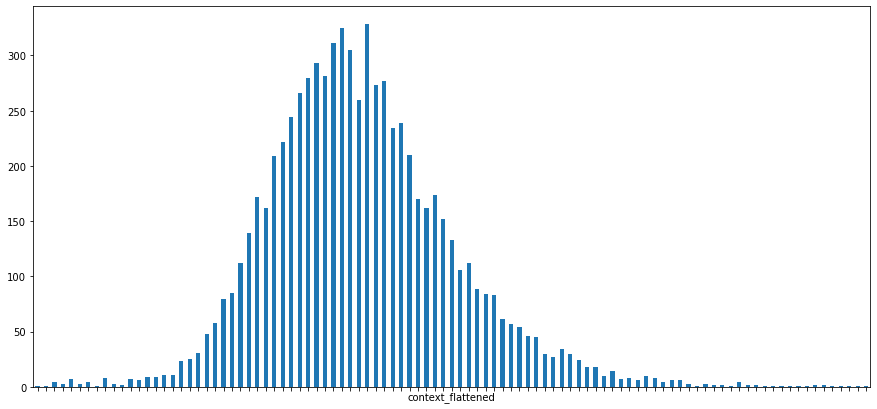

In [61]:
# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally
plt.setp(plot.axes.get_xticklabels(), visible=False)      # hide all labels
plt.setp(plot.axes.get_xticklabels()[::5], visible=True)  # set every 5 labels visible
plt.show() 

#### answer

In [62]:
dev_question_df.answer = dev_question_df.answer.map(normalize_answer)  # apply normalize_answer(answer)  

In [63]:
dev_question_df.answer.str.split(' ').str.len().describe()  # statistic of number of words in the answer

count    7405.000000
mean        2.360837
std         1.659080
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        28.000000
Name: answer, dtype: float64

In [64]:
grouped = dev_question_df.groupby(dev_question_df.answer.str.split(' ').str.len())
num_of_answer_words = grouped.size()  # count of each 
num_of_answer_words

answer
1     2441
2     2403
3     1442
4      577
5      247
6      103
7       71
8       44
9       20
10      12
11      11
12      13
13       6
14       5
15       5
16       2
17       1
22       1
28       1
dtype: int64

In [65]:
# number of questions with answer 'yes'
dev_question_df.loc[dev_question_df['answer'] == 'yes'].shape[0]

225

In [66]:
# number of comparison questions with answer 'yes'
dev_question_df.loc[(dev_question_df['answer'] == 'yes') & (dev_question_df['type'] == 'comparison')].shape[0]

225

In [67]:
# number of questions with answer 'no'
dev_question_df.loc[dev_question_df['answer'] == 'no'].shape[0]

233

In [68]:
# number of comparison questions with answer 'no'
dev_question_df.loc[(dev_question_df['answer'] == 'no') & (dev_question_df['type'] == 'comparison')].shape[0]

233

questions with answer yes/no are all comparison questions, and (1487-225-233) = 69.2% comparison questions have span answers 

In [69]:
# dev_question_df["normalized_answer_in_context"] = dev_question_df.apply(lambda row: row['answer'] in row['context_joint'], axis=1)

In [70]:
dev_question_df['normalized_answer_in_context'] = dev_question_df.apply(lambda row:  findWord(row['answer'], row['context_joint']) == True , axis = 1)

In [71]:
dev_question_df.normalized_answer_in_context.describe()

count     7405
unique       2
top       True
freq      7191
Name: normalized_answer_in_context, dtype: object

7191 questions' answer in the context, 7405-7191 = 214 questions' answer are not in the context

In [72]:
dev_question_df.loc[(dev_question_df['normalized_answer_in_context'] == False) & (dev_question_df['answer'] != 'yes') & (dev_question_df['answer'] != 'no') & (dev_question_df['answer'] != '')]

Empty DataFrame
Columns: [_id, answer, question, supporting_facts, context, type, level, context_flattened, context_joint, normalized_answer_in_context]
Index: []

In [73]:
dev_question_df.loc[(dev_question_df['normalized_answer_in_context'] == False)].answer.describe()

count     214
unique      2
top       yes
freq      212
Name: answer, dtype: object

In [74]:
dev_question_df.loc[(dev_question_df['normalized_answer_in_context'] == False) & (dev_question_df['answer'] != 'yes') & (dev_question_df['answer'] != 'no')].answer.describe()

count     2
unique    1
top        
freq      2
Name: answer, dtype: object

#### supporting facts

In [75]:
dev_question_df['invalid_supporting_facts_ids'] = dev_question_df.apply(lambda row: True in [sp_idx >= len(dict(row['context'])[sp_t]) for (sp_t, sp_idx) in row['supporting_facts']], axis = 1)

In [76]:
dev_question_df['invalid_supporting_facts_ids'].describe()

count      7405
unique        2
top       False
freq       7404
Name: invalid_supporting_facts_ids, dtype: object

1 questions have at least a supporting fact id out of range. That is, supporting fact id >= total num of sentence in the paragraph

In [77]:
dev_question_df.loc[dev_question_df['invalid_supporting_facts_ids']==True]

_id    answer  \
5059  5ae61bfd5542992663a4f261  swingman   

                                                                         question  \
5059  Which teams did Jimmy Butler play and what role did he play on these teams?   

                                                                                                  supporting_facts  \
5059  [[Shooting guard, 4], [Shooting guard, 5], [Jimmy Butler (basketball), 0], [Jimmy Butler (basketball), 902]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [78]:
# print(dev_question_df.iloc[514].context[7])
# len(dev_question_df.iloc[514].context[7])

In [79]:
dev_question_df['supporting_fact_text'] = dev_question_df.apply(lambda row: [normalize_answer(dict(row['context'])[sp_t][sp_idx]) for (sp_t, sp_idx) in row['supporting_facts'] if(sp_idx < len(dict(row['context'])[sp_t])) ], axis = 1)

In [80]:
dev_question_df.head(3)

_id             answer  \
0  5a8b57f25542995d1e6f1371                yes   
1  5a8c7595554299585d9e36b6  chief of protocol   
2  5a85ea095542994775f606a8          animorphs   

                                                                                                                                                  question  \
0                                                                                               Were Scott Derrickson and Ed Wood of the same nationality?   
1                                                   What government position was held by the woman who portrayed Corliss Archer in the film Kiss and Tell?   
2  What science fantasy young adult series, told in first person, has a set of companion books narrating the stories of enslaved worlds and alien species?   

                                                                                                                   supporting_facts  \
0                                                                                             [[Scott Derrickson, 0], [Ed Wood, 0]]   
1                                                        [[Kiss and Tell (1945 film), 0], [Shirley Temple, 0], [Shirley Temple, 1]]   
2  [[The Hork-Bajir Chronicles, 0], [The Hork-Bajir Chronicles, 1], [The Hork-Bajir Chronicles, 2], [Animorphs, 0], [Animorphs, 1]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [81]:
# add a column to count the number of supporting facts
dev_question_df['num_of_supporting_facts'] = dev_question_df.supporting_fact_text.str.len()

In [82]:
# Distribution of number of supporting facts
dev_question_df.num_of_supporting_facts.describe()

count    7405.000000
mean        2.431330
std         0.711328
min         2.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         8.000000
Name: num_of_supporting_facts, dtype: float64

In [83]:
# Distribution of number of supporting facts
grouped = dev_question_df.groupby(['num_of_supporting_facts'])
num_of_supporting_facts_counts = grouped.size()  # count of each 
num_of_supporting_facts_counts

num_of_supporting_facts
2    4990
3    1775
4     536
5      80
6      14
7       9
8       1
dtype: int64

In [84]:
# check thoese questions with more than 8 supportiing facts
dev_question_df.loc[dev_question_df.num_of_supporting_facts == 8]

_id    answer  \
5262  5abab18d55429901930fa89e  lola dee   

                                                                                                                                                                            question  \
5262  The man Tony Bennet called "The Father of Rock and Roll" once toured with what singer who once auditioned for "Junior Junction", and landed a recording contract in her teens?   

                                                                                                                       supporting_facts  \
5262  [[Lola Dee, 0], [Lola Dee, 1], [Lola Dee, 2], [Lola Dee, 3], [Lola Dee, 4], [Johnnie Ray, 0], [Johnnie Ray, 1], [Johnnie Ray, 2]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [85]:
# add a column: whether each supporting fact contains the answer string or not
dev_question_df['normalized_answer_in_supporting_fact'] = dev_question_df.apply(lambda row: [ findWord(row['answer'], f) == True for f in row['supporting_fact_text']], axis = 1)
dev_question_df['normalized_answer_in_supporting_fact']

0                          [False, False]
1                    [False, False, True]
2       [True, False, False, True, False]
3                          [False, False]
4                           [False, True]
                      ...                
7400                  [False, True, True]
7401                         [True, True]
7402                       [False, False]
7403                       [False, False]
7404                        [False, True]
Name: normalized_answer_in_supporting_fact, Length: 7405, dtype: object

In [86]:
dev_question_df.head(3)

_id             answer  \
0  5a8b57f25542995d1e6f1371                yes   
1  5a8c7595554299585d9e36b6  chief of protocol   
2  5a85ea095542994775f606a8          animorphs   

                                                                                                                                                  question  \
0                                                                                               Were Scott Derrickson and Ed Wood of the same nationality?   
1                                                   What government position was held by the woman who portrayed Corliss Archer in the film Kiss and Tell?   
2  What science fantasy young adult series, told in first person, has a set of companion books narrating the stories of enslaved worlds and alien species?   

                                                                                                                   supporting_facts  \
0                                                                                             [[Scott Derrickson, 0], [Ed Wood, 0]]   
1                                                        [[Kiss and Tell (1945 film), 0], [Shirley Temple, 0], [Shirley Temple, 1]]   
2  [[The Hork-Bajir Chronicles, 0], [The Hork-Bajir Chronicles, 1], [The Hork-Bajir Chronicles, 2], [Animorphs, 0], [Animorphs, 1]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [87]:
# questions that none of its supporting facts contains the answer string
# that is, rows that dev_question_df['supporting_fact_contain_answer'] is a list of false
dev_question_df[dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x)))] 

_id answer  \
0     5a8b57f25542995d1e6f1371    yes   
3     5adbf0a255429947ff17385a     no   
9     5a8db19d5542994ba4e3dd00    yes   
17    5ab29c24554299449642c932    yes   
27    5abd259d55429924427fcf1a    yes   
...                        ...    ...   
7339  5ae3d0bb5542990afbd1e1e5    yes   
7349  5a7fe0b55542994857a76818     no   
7373  5ab8736455429916710eb058    yes   
7402  5a8173fa554299260e20a28e    yes   
7403  5a8caf1d554299585d9e3720    yes   

                                                                                                    question  \
0                                                 Were Scott Derrickson and Ed Wood of the same nationality?   
3                            Are the Laleli Mosque and Esma Sultan Mansion located in the same neighborhood?   
9                                                   Are Local H and For Against both from the United States?   
17                                             Are Giuseppe Verdi and Ambroise Thomas both Opera composers ?   
27                                                  Are both Dictyosperma, and Huernia described as a genus?   
...                                                                                                      ...   
7339                               are Dee Dee Ramone and Alex Band both singers, songwriters and musicians?   
7349                                                       Are The Maine and Black both from Tempe, Arizona?   
7373                                                                     Are Yut and Tsuro both board games?   
7402   Are Billy and Barak both breeds of scenthound? (Barak is also known as a Bosnian Coarse-haired Hound)   
7403  Were both of the following rock groups formed in California: Dig and Thinking Fellers Union Local 282?   

                                              supporting_facts  \
0                        [[Scott Derrickson, 0], [Ed Wood, 0]]   
3               [[Laleli Mosque, 0], [Esma Sultan Mansion, 0]]   
9                             [[Local H, 0], [For Against, 0]]   
17                 [[Giuseppe Verdi, 0], [Ambroise Thomas, 0]]   
27                           [[Dictyosperma, 0], [Huernia, 0]]   
...                                                        ...   
7339                     [[Dee Dee Ramone, 0], [Alex Band, 0]]   
7349    [[The Maine (band), 0], [Black (Bangladeshi band), 0]]   
7373                                    [[Yut, 0], [Tsuro, 0]]   
7402      [[Bosnian Coarse-haired Hound, 0], [Billy (dog), 0]]   
7403  [[Dig (band), 0], [Thinking Fellers Union Local 282, 0]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

According to the results, there are 341 such questions that the answer string is not in any of the supporting facts.

In [88]:
# questions that none of its supporting facts contains the answer string, and its answer is neither 'yes' nor 'no'
dev_question_df.loc[dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x))) & (dev_question_df['answer'] != 'yes') & (dev_question_df['answer'] != 'no') & (dev_question_df['answer'] != '') ].shape[0]

4

In [89]:
dev_question_df.loc[dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: not(any(x))) & (dev_question_df['answer'] != 'yes') & (dev_question_df['answer'] != 'no') & (dev_question_df['answer'] != '') ]

_id                      answer  \
289   5a7555215542996c70cfaee1  hey pa theres goat on roof   
520   5abdd08d5542991f6610604c   guardians of galaxy vol 2   
1785  5adde6535542990dbb2f7ef9       hail hail rock n roll   
2211  5ab4b9f75542990594ba9ca4       people and carnabeats   

                                                                                          question  \
289               Which came to market first, "Hey Pa! There's a Goat on the Roof" or "Poleconomy"   
520   Which movie directed by James Gunn portrayed the fictional character, Ego the Living Planet?   
1785              Which documentary was filmed first, Almost Sunrise or Hail! Hail! Rock 'n' Roll?   
2211                                               Who covered the song I Love You by Chris Write?   

                                                                                           supporting_facts  \
289                                              [[Hey Pa! There's a Goat on the Roof, 1], [Poleconomy, 0]]   
520                                       [[Ego the Living Planet, 2], [Guardians of the Galaxy Vol. 2, 3]]   
1785                                                  [[Almost Sunrise, 0], [Hail! Hail! Rock 'n' Roll, 2]]   
2211  [[I Love You (The Zombies song), 0], [I Love You (The Zombies song), 1], [Chris White (musician), 0]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

According to the results, there are only 4 questions that the answer string is not in any of the supporting facts and the answer is not 'yes', 'no', or ''.
This caused by 
    - answer in sp title
    - answer cross sp sentences.

[289]
- answer: hey pa theres goat on roof
- sp contains:
    - theres goat on roof
- sp tilte:
    - Hey Pa! There's a Goat on the Roof
    
[2211]
- answr: people and carnabeats
- sp contains:
    - which was covered by people
    - and carnabeats and by several other artists including foreign translations



In [90]:
# how many supporting facts contains the answer string, that is, the count of 'True'
dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)).describe()

count    7405.00000
mean        1.12181
std         0.46372
min         0.00000
25%         1.00000
50%         1.00000
75%         1.00000
max         4.00000
Name: normalized_answer_in_supporting_fact, dtype: float64

In [91]:
grouped = dev_question_df.groupby(dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)))
num_of_supporting_fact_contain_answer = grouped.size()  # count of each 
num_of_supporting_fact_contain_answer

normalized_answer_in_supporting_fact
0     341
1    5875
2    1140
3      44
4       5
dtype: int64

In [92]:
# check thoese questions with 5 supporting facts contain the answer
dev_question_df.loc[dev_question_df['normalized_answer_in_supporting_fact'].map(lambda x: sum(x)) == 5]

Empty DataFrame
Columns: [_id, answer, question, supporting_facts, context, type, level, context_flattened, context_joint, normalized_answer_in_context, invalid_supporting_facts_ids, supporting_fact_text, num_of_supporting_facts, normalized_answer_in_supporting_fact]
Index: []

In [93]:
dev_question_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   _id                                   7405 non-null   object
 1   answer                                7405 non-null   object
 2   question                              7405 non-null   object
 3   supporting_facts                      7405 non-null   object
 4   context                               7405 non-null   object
 5   type                                  7405 non-null   object
 6   level                                 7405 non-null   object
 7   context_flattened                     7405 non-null   object
 8   context_joint                         7405 non-null   object
 9   normalized_answer_in_context          7405 non-null   bool  
 10  invalid_supporting_facts_ids          7405 non-null   bool  
 11  supporting_fact_text          

## Reduced context with phrase Graph

### Train_reduced_context 

In [163]:
with open('/xdisk/msurdeanu/fanluo/hotpotQA/hotpot_train_reduced_context.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data))[0]["data"]   
train_reduced_context_df = pd.json_normalize(data, "paragraphs")
 
del data
import gc
gc.collect()

90494

In [164]:
train_reduced_context_df.head(3)

context  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   <t> radio city indian radio station </t> it plays hindi english and regional songs [/sent] <t> history of albanian football </t> albanian national team was founded on june 6 1930 but albania had to wait 16 years to play its first international match and then defeated yugoslavia in 1946 [/sent] in 1932 albania joined fifa during 12–16 june convention and in 1954 she was one of founding members of uefa [/sent] <t> echosmith </t> until they signed to warner bros [/sent] <t> womens colleges in southern united states </t> many started first as girls seminaries or academies [/sent] salem college is oldest female educational institution in south and wesleyan college is first that was established specifically as college for women [/sent] some schools such as mary baldwin university and salem college offer coeducational courses at graduate level [/sent] <t> first arthur county courthouse and jail </t>  [/sent] <t> arthurs magazine </t>  [/sent] <t> 2014–15 ukrainian hockey championship </t>  [/sent] <t> first for women </t> first for women is womans magazine published by bauer media group in usa [/sent] magazine was started in 1989 [/sent] it is based in englewood cliffs new jersey [/sent] <t> freeway complex fire </t> these two separate fires merged day later and ultimately destroyed 314 residences in anaheim hills and yorba linda [/sent] <t> william rast </t> label also produces other clothing items such as jackets and tops [/sent]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     <t> ritzcarlton jakarta </t>  [/sent] <t> oberoi family </t> oberoi family is indian family that is famous for its involvement in hotels namely through oberoi group [/sent] <t> ishqbaaaz </t> show initially focused on tale of three brothers later become centered on love story of shivaay and annika surbhi chandna with story of omkara and rudra being shifted to spinoff series dil boley oberoi [/sent] <t> hotel tallcorn </t> hotel tallcorn is located in marshalltown iowa [/sent] today it is called tallcorn towers apartments [/sent] tallcorn was listed as contributing property in marshalltown downtown historic district on national register of historic places in 2002 [/sent] <t> mohan singh oberoi </t>  [/sent] <t> hotel bond </t>  [/sent] <t> oberoi group </t> oberoi group is hotel company with its head office in delhi [/sent] founded in 1934 company owns andor operates 30 luxury hotels and two river cruise ships in six countries primarily under its oberoi hotels resorts and trident hotels brands [/sent] <t> future fibre technologies </t>  [/sent] <t> 289th military police company </t>  [/sent] <t> glennwanis hotel </t>  

In [165]:
qas_df = pd.json_normalize(train_reduced_context_df.qas.map(lambda x: x[0])) 
qas_df

answer                        id  \
0                arthurs magazine  5a7a06935542990198eaf050   
1                           delhi  5a879ab05542996e4f30887e   
2         president richard nixon  5a8d7341554299441c6b9fe5   
3                        american  5a82171f5542990a1d231f4a   
4                         alcohol  5a84dd955542997b5ce3ff79   
...                           ...                       ...   
90442                    american  5a8f8db25542997ba9cb32b9   
90443        simon property group  5ae4f3615542993aec5ec0fd   
90444             amblin partners  5a903fc95542990a984935bd   
90445         mv wilhelm gustloff  5ab56e71554299494045efc8   
90446  2017 southeast asian games  5ac28e915542996366519a0a   

                                                                                                                                            question  \
0                                                                             Which magazine was started first Arthur's Magazine or First for Women?   
1                                                                  The Oberoi family is part of a hotel company that has a head office in what city?   
2                    Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?   
3                                                                                                    What nationality was James Henry Miller's wife?   
4                                                                     Cadmium Chloride is slightly soluble in this chemical, it is also called what?   
...                                                                                                                                              ...   
90442                                                                                  Kerry Remsen is the daughter of an actor with what ethnicity?   
90443  Who manages both Northshore Mall in Peabody, Massachusetts and the Liberty Tree Mall in Danvers which are less than one mile from each other?   
90444                                           Charlee Johnson was part of a band that signed with a film production label of what company in 2000?   
90445                                                              What is the ship that sank in the Baltic sea and is in the novel Salt to the Sea?   
90446                                                                 Vietnam national cricket team will debut at what competitions at  Kinrara Oval   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    is_sup_fact  \
0                                                                                                                                                              [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False]   
1                                                                                                                                                                                                               [False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False]

In [166]:
train_reduced_context_df = pd.concat([train_reduced_context_df.context, qas_df], axis=1)
train_reduced_context_df.head(3)

context  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   <t> radio city indian radio station </t> it plays hindi english and regional songs [/sent] <t> history of albanian football </t> albanian national team was founded on june 6 1930 but albania had to wait 16 years to play its first international match and then defeated yugoslavia in 1946 [/sent] in 1932 albania joined fifa during 12–16 june convention and in 1954 she was one of founding members of uefa [/sent] <t> echosmith </t> until they signed to warner bros [/sent] <t> womens colleges in southern united states </t> many started first as girls seminaries or academies [/sent] salem college is oldest female educational institution in south and wesleyan college is first that was established specifically as college for women [/sent] some schools such as mary baldwin university and salem college offer coeducational courses at graduate level [/sent] <t> first arthur county courthouse and jail </t>  [/sent] <t> arthurs magazine </t>  [/sent] <t> 2014–15 ukrainian hockey championship </t>  [/sent] <t> first for women </t> first for women is womans magazine published by bauer media group in usa [/sent] magazine was started in 1989 [/sent] it is based in englewood cliffs new jersey [/sent] <t> freeway complex fire </t> these two separate fires merged day later and ultimately destroyed 314 residences in anaheim hills and yorba linda [/sent] <t> william rast </t> label also produces other clothing items such as jackets and tops [/sent]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     <t> ritzcarlton jakarta </t>  [/sent] <t> oberoi family </t> oberoi family is indian family that is famous for its involvement in hotels namely through oberoi group [/sent] <t> ishqbaaaz </t> show initially focused on tale of three brothers later become centered on love story of shivaay and annika surbhi chandna with story of omkara and rudra being shifted to spinoff series dil boley oberoi [/sent] <t> hotel tallcorn </t> hotel tallcorn is located in marshalltown iowa [/sent] today it is called tallcorn towers apartments [/sent] tallcorn was listed as contributing property in marshalltown downtown historic district on national register of historic places in 2002 [/sent] <t> mohan singh oberoi </t>  [/sent] <t> hotel bond </t>  [/sent] <t> oberoi group </t> oberoi group is hotel company with its head office in delhi [/sent] founded in 1934 company owns andor operates 30 luxury hotels and two river cruise ships in six countries primarily under its oberoi hotels resorts and trident hotels brands [/sent] <t> future fibre technologies </t>  [/sent] <t> 289th military police company </t>  [/sent] <t> glennwanis hotel </t>  

In [167]:
train_reduced_context_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90447 entries, 0 to 90446
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   context             90447 non-null  object
 1   answer              90447 non-null  object
 2   id                  90447 non-null  object
 3   question            90447 non-null  object
 4   is_sup_fact         90447 non-null  object
 5   is_supporting_para  90447 non-null  object
dtypes: object(6)
memory usage: 4.1+ MB


In [168]:
train_reduced_context_df.context[2]

'<t> lisa simpson </t> groening had been invited to pitch series of shorts based on his comic life in hell but instead decided to create new set of characters [/sent] <t> marge simpson </t> groening had been called to pitch series of shorts based on life in hell but instead decided to create new set of characters [/sent] <t> bart simpson </t> groening had been called to pitch series of shorts based on his comic strip life in hell but instead decided to create new set of characters [/sent] <t> allie goertz </t> allison beth allie goertz born march 2 1991 is american musician [/sent] her style has been compared to that of bo burnham [/sent] <t> milhouse van houten </t> later in series it is revealed that milhouses middle name is mussolini [/sent] <t> los angeles reader </t> los angeles reader was weekly paper established in 1978 and distributed in los angeles united states [/sent] it followed format of still active chicago reader [/sent] groening was also originally reader music critic [

#### reduced Context 

In [169]:
train_reduced_context_df.context.str.findall("\[/sent\]").str.len().describe()  # statistic of number of context sentences

count    90447.000000
mean        14.624907
std          4.456624
min          2.000000
25%         12.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: context, dtype: float64

In [170]:
grouped = train_reduced_context_df.groupby(train_reduced_context_df.context.str.findall("\[/sent\]").str.len())
num_of_context_sentences = grouped.size()  # count of each 
num_of_context_sentences

context
2        71
3       129
4       142
5       107
6        89
7        65
8        70
9        62
10     9071
11    11998
12    12653
13    11169
14     8948
15     7350
16     5933
17     4596
18     3791
19     3007
20     2333
21     1861
22     1486
23     1153
24      980
25      712
26      585
27      464
28      364
29      263
30      205
31      180
32      139
33       94
34       84
35       58
36       58
37       33
38       30
39       23
40       22
41       17
42        9
43        8
44        3
45        9
46        4
47        5
48        1
49        4
50        1
52        1
54        2
61        1
62        1
63        1
64        1
66        1
dtype: int64

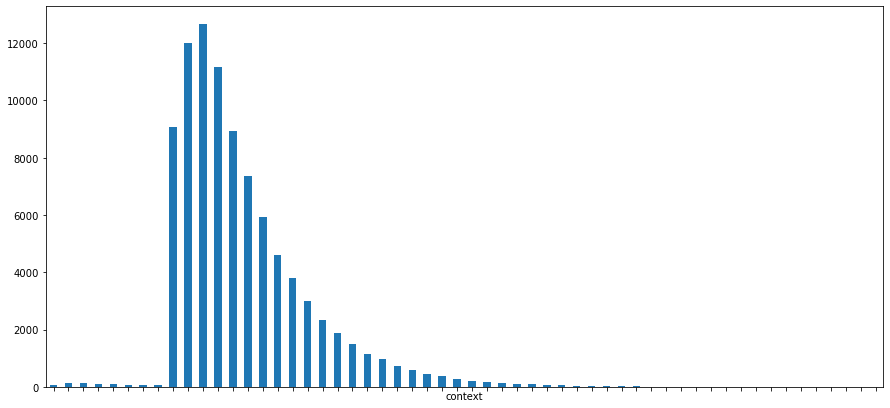

In [171]:
# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally
plt.setp(plot.axes.get_xticklabels(), visible=False)      # hide all labels
plt.setp(plot.axes.get_xticklabels()[::5], visible=True)  # set every 5 labels visible
plt.show() 

#### answer

In [172]:
train_reduced_context_df.answer.str.split(' ').str.len().describe()  # statistic of number of words in the answer

count    90447.000000
mean         2.144328
std          1.641551
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         76.000000
Name: answer, dtype: float64

In [173]:
# train_reduced_context_df["normalized_answer_in_reduced_context"] = train_reduced_context_df.apply(lambda row: row['answer'] in row['context'], axis=1)

In [174]:
train_reduced_context_df['normalized_answer_in_reduced_context'] = train_reduced_context_df.apply(lambda row:  findWord(row['answer'], row['context']) == True , axis = 1)

In [175]:
train_reduced_context_df.normalized_answer_in_reduced_context.describe()

count     90447
unique        2
top        True
freq      58625
Name: normalized_answer_in_reduced_context, dtype: object

58625 questions' answer in the context, 90447-58625 = 31822 questions' answer are not in the reduced context

In [176]:
train_reduced_context_df.loc[(train_reduced_context_df['normalized_answer_in_reduced_context'] == True) | (train_reduced_context_df['answer'] == 'yes') | (train_reduced_context_df['answer'] == 'no')].shape[0]

61639

In [177]:
train_reduced_context_df.loc[(train_reduced_context_df['normalized_answer_in_reduced_context'] == False) & (train_reduced_context_df['answer'] != 'yes') & (train_reduced_context_df['answer'] != 'no') & (train_reduced_context_df['answer'] != '')].shape[0]

28801

#### supporting facts

In [178]:
train_joint_df = train_question_df.join(train_reduced_context_df, rsuffix='_reduced_context')
train_joint_df

supporting_facts  \
0                                                                                [[Arthur's Magazine, 0], [First for Women, 0]]   
1                                                                                   [[Oberoi family, 0], [The Oberoi Group, 0]]   
2                                           [[Allie Goertz, 0], [Allie Goertz, 1], [Allie Goertz, 2], [Milhouse Van Houten, 0]]   
3                                                                     [[Peggy Seeger, 0], [Peggy Seeger, 1], [Ewan MacColl, 0]]   
4                                                                                         [[Cadmium chloride, 1], [Ethanol, 0]]   
...                                                                                                                         ...   
90442                                                                                     [[Kerry Remsen, 1], [Bert Remsen, 0]]   
90443                                                      [[Northshore Mall, 0], [Northshore Mall, 4], [Liberty Tree Mall, 0]]   
90444                                                                                   [[Charlee Johnson, 4], [DreamWorks, 0]]   
90445                                                                          [[Salt to the Sea, 1], [MV Wilhelm Gustloff, 0]]   
90446  [[Vietnam national cricket team, 0], [Vietnam national cricket team, 1], [Cricket at the 2017 Southeast Asian Games, 0]]   

        level  \
0      medium   
1      medium   
2        hard   
3      medium   
4      medium   
...       ...   
90442  medium   
90443    easy   
90444  medium   
90445  medium   
90446  medium   

                                                                                                                                            question  \
0                                                                             Which magazine was started first Arthur's Magazine or First for Women?   
1                                                                  The Oberoi family is part of a hotel company that has a head office in what city?   
2                    Musician and satirist Allie Goertz wrote a song about the "The Simpsons" character Milhouse, who Matt Groening named after who?   
3                                                                                                    What nationality was James Henry Miller's wife?   
4                                                                     Cadmium Chloride is slightly soluble in this chemical, it is also called what?   
...                                                                                                                                              ...   
90442                                                                                  Kerry Remsen is the daughter of an actor with what ethnicity?   
90443  Who manages both Northshore Mall in Peabody, Massachusetts and the Liberty Tree Mall in Danvers which are less than one mile from each other?   
90444                                           Charlee Johnson was part of a band that signed with a film production label of what company in 2000?   
90445                                                              What is the ship that sank in the Baltic sea and is in the novel Salt to the Sea?   
90446                                                                 Vietnam national cricket team will debut at what competitions at  Kinrara Oval   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [179]:
train_joint_df['sp_in_reduced_context'] = train_joint_df.apply(lambda row: [ f in row['context_reduced_context'] for f in row['supporting_fact_text']], axis = 1)
train_joint_df['sp_in_reduced_context']

0                      [False, True]
1                       [True, True]
2        [True, False, False, False]
3              [False, False, False]
4                      [True, False]
                    ...             
90442                  [True, False]
90443            [True, False, True]
90444                 [False, False]
90445                  [True, False]
90446             [True, True, True]
Name: sp_in_reduced_context, Length: 90447, dtype: object

In [180]:
# how many supporting facts contained in the reduced context, that is, the count of 'True' / count of sp
train_joint_df['sp_in_reduced_context_ratio'] = train_joint_df['sp_in_reduced_context'].map(lambda x: sum(x) / len(x)) 
train_joint_df['sp_in_reduced_context_ratio']

0        0.500000
1        1.000000
2        0.250000
3        0.000000
4        0.500000
           ...   
90442    0.500000
90443    0.666667
90444    0.000000
90445    0.500000
90446    1.000000
Name: sp_in_reduced_context_ratio, Length: 90447, dtype: float64

In [181]:
train_joint_df['sp_in_reduced_context_ratio'].describe()

count    90447.000000
mean         0.502870
std          0.357188
min          0.000000
25%          0.250000
50%          0.500000
75%          0.750000
max          1.000000
Name: sp_in_reduced_context_ratio, dtype: float64

In [182]:
# Distribution of number of supporting facts in reduced_context
train_joint_df['num_of_sp_in_reduced_context'] = train_joint_df['sp_in_reduced_context'].map(lambda x: sum(x))
grouped = train_joint_df.groupby(['num_of_sp_in_reduced_context'])
num_of_sp_in_reduced_context_counts = grouped.size()  # count of each 
num_of_sp_in_reduced_context_counts

num_of_sp_in_reduced_context
0    21635
1    35901
2    27862
3     4425
4      572
5       44
6        8
dtype: int64

In [183]:
# reduced_context contains the answer, even though does not contain any supporting fact
train_joint_df.loc[(train_joint_df.num_of_sp_in_reduced_context == 0) & (train_joint_df.normalized_answer_in_reduced_context == True)].shape[0]

8764

In [184]:
train_joint_df.loc[(train_joint_df.num_of_sp_in_reduced_context == 0) & (train_joint_df.normalized_answer_in_reduced_context == True)].head(3)

supporting_facts  \
18                                                          [[Dua Lipa, 5], [New Rules (song), 0]]   
19                                     [[Joe Heck, 0], [Joe Heck, 2], [Catherine Cortez Masto, 2]]   
44  [[The Battle (George Jones song), 0], [The Battle (George Jones song), 5], [Tammy Wynette, 0]]   

     level  \
18    easy   
19    easy   
44  medium   

                                                                                                                                                                                                     question  \
18  Dua Lipa, an English singer, songwriter and model, the album spawned the number-one single "New Rules" is a song by English singer Dua Lipa from her eponymous debut studio album, released in what year?   
19                                              American politician Joe Heck ran unsuccessfully against Democrat Catherine Cortez Masto, a woman who previously served as the 32nd Attorney General of where?   
44                                                  What American country music singer-songwriter, born in May of 1942, sang a duet with her ex-husband the same year that he released the song "The Battle?"   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [185]:
train_joint_df['sp_text_reduced_context'] = train_joint_df.apply(lambda row: [ f for f in row['supporting_fact_text'] if f in row['context_reduced_context'] ], axis = 1)
train_joint_df['sp_text_reduced_context']

0                                                                                                                                                                                                                     [first for women is womans magazine published by bauer media group in usa]
1                                                                                                                         [oberoi family is indian family that is famous for its involvement in hotels namely through oberoi group, oberoi group is hotel company with its head office in delhi]
2                                                                                                                                                                                                                             [allison beth allie goertz born march 2 1991 is american musician]
3                                                                                                                                    

In [186]:
train_joint_df['normalized_answer_in_reduced_sp_text'] = train_joint_df.apply(lambda row: any([ findWord(row['answer'], f) == True for f in row['sp_text_reduced_context']]), axis = 1)
train_joint_df['normalized_answer_in_reduced_sp_text']

0        False
1         True
2        False
3        False
4         True
         ...  
90442    False
90443     True
90444    False
90445     True
90446     True
Name: normalized_answer_in_reduced_sp_text, Length: 90447, dtype: bool

In [187]:
train_joint_df.normalized_answer_in_reduced_sp_text.describe()

count     90447
unique        2
top       False
freq      48186
Name: normalized_answer_in_reduced_sp_text, dtype: object

58625 questions' answer in the context, 90447-58625 = 31822 questions' answer are not in the reduced context

In [188]:
train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_sp_text'] == False) & (train_joint_df['answer'] != 'yes') & (train_joint_df['answer'] != 'no') & (train_joint_df['answer'] != '')].shape[0]

44050

In [189]:
# reduced_context contain the answer, but the sp in reduced context does not contain the answer
train_joint_df.loc[(train_joint_df.normalized_answer_in_reduced_context == True) & (train_joint_df.normalized_answer_in_reduced_sp_text == False) ].shape[0]

16364

In [190]:
train_joint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90447 entries, 0 to 90446
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   supporting_facts                      90447 non-null  object 
 1   level                                 90447 non-null  object 
 2   question                              90447 non-null  object 
 3   context                               90447 non-null  object 
 4   answer                                90447 non-null  object 
 5   _id                                   90447 non-null  object 
 6   type                                  90447 non-null  object 
 7   context_flattened                     90447 non-null  object 
 8   context_joint                         90447 non-null  object 
 9   normalized_answer_in_context          90447 non-null  bool   
 10  invalid_supporting_facts_ids          90447 non-null  bool   
 11  supporting_fact

In [191]:
# train longformer on context vs reduced_context, run time and performance for traning/dev
# just over the questions has answer in the reduced_context
# Thus save file contains only the questions has answer in the reduced_context

hotpot_reduced_train_df = train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no') , ['supporting_facts', 'context', 'answer', '_id', 'question']]
hotpot_reduced_train_df

#hotpot_reduced_train_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/hotpot_reduced_train.json", orient="records") 

In [192]:
def convert_to_raw_context(context_joint):
    raw = []
    for para in [s.split('</t>') for s in context_joint]: 
        if len(para) > 1:  # split into tile and sents
            raw_para=[]
            sents = []
            for sent in para[1].split('[/sent]'):
                if(normalize_answer(sent) != ''):
                    sents.append(sent)
            if(len(sents) > 0):
                raw_para.append(normalize_answer(para[0]))
                raw_para.append(sents)
                raw.append(raw_para)
            
    return raw

In [193]:
train_joint_df['raw_reduced_context'] = train_joint_df.context_reduced_context.str.split(pat='<t>').map(convert_to_raw_context)

In [194]:
train_joint_df.raw_reduced_context[0]

[['radio city indian radio station',
  [' it plays hindi english and regional songs ']],
 ['history of albanian football',
  [' albanian national team was founded on june 6 1930 but albania had to wait 16 years to play its first international match and then defeated yugoslavia in 1946 ',
   ' in 1932 albania joined fifa during 12–16 june convention and in 1954 she was one of founding members of uefa ']],
 ['echosmith', [' until they signed to warner bros ']],
 ['womens colleges in southern united states',
  [' many started first as girls seminaries or academies ',
   ' salem college is oldest female educational institution in south and wesleyan college is first that was established specifically as college for women ',
   ' some schools such as mary baldwin university and salem college offer coeducational courses at graduate level ']],
 ['first for women',
  [' first for women is womans magazine published by bauer media group in usa ',
   ' magazine was started in 1989 ',
   ' it is bas

In [195]:
# save file contains only the questions with reduced_context has answer in the reduced_context

hotpot_train_reduced_context_df = train_joint_df.loc[(train_joint_df['normalized_answer_in_reduced_context'] == True) | (train_joint_df['answer'] == 'yes') | (train_joint_df['answer'] == 'no') , ['supporting_facts', 'raw_reduced_context', 'answer', '_id', 'question']]
hotpot_train_reduced_context_df.rename(columns={"raw_reduced_context": "context"})

#hotpot_train_reduced_context_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/hotpot_reduced_train_reduced_context.json", orient="records") 

### Dev_reduced_context 

In [196]:
with open('/xdisk/msurdeanu/fanluo/hotpotQA/hotpot_dev_distractor_reduced_context.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data))[0]["data"]   
dev_reduced_context_df = pd.json_normalize(data, "paragraphs")
 
del data
import gc
gc.collect()

7463

In [197]:
dev_reduced_context_df.head(3)

context  \
0                                                                                                                                                                                            <t> ed wood film </t> ed wood is 1994 american biographical period comedydrama film directed and produced by tim burton and starring johnny depp as cult filmmaker ed wood [/sent] film concerns period in woods life when he made his bestknown films as well as his relationship with actor bela lugosi played by martin landau [/sent] <t> scott derrickson </t> scott derrickson born july 16 1966 is american director screenwriter and producer [/sent] he lives in los angeles california [/sent] <t> woodson arkansas </t>  [/sent] <t> tyler bates </t>  [/sent] <t> ed wood </t> edward davis wood jr october 10 1924 – december 10 1978 was american filmmaker actor writer producer and director [/sent] <t> deliver us from evil 2014 film </t> film is officially based on 2001 nonfiction book entitled beware night by ralph sarchie and lisa collier cool and its marketing campaign highlighted that it was inspired by actual accounts [/sent] <t> adam collis </t>  [/sent] <t> sinister film </t> it stars ethan hawke as fictional truecrime writer ellison oswalt who discovers box of home movies in his attic that puts his family in danger [/sent] <t> conrad brooks </t> he also has since gone on to write produce and direct several films [/sent] <t> doctor strange 2016 film </t> in doctor strange surgeon strange learns mystic arts after careerending car accident [/sent]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     <t> meet corliss archer </t> meet corliss archer program from radios golden age ran from january 7 1943 to september 30 1956 [/sent] although it was cbss answer to nbcs popular date with judy it was also broadcast by nbc in 1948 as summer replacement for bob hope show [/sent] <t> shirley temple </t>  [/sent] <t> janet waldo </t>  [/sent] <t> meet corliss archer tv series </t> program was adaptation of radio series of same name which was based on series of short stories by f hugh herbert [/sent] <t> lord high treasurer </t>  [/sent] <t> kiss for corliss </t>  [/sent] <t> kiss and tell 1945 film </t> in film two teenage girls cause their respective parents much concern when they start to become interested in boys [/sent] <t> secretary of state for constitutional affairs </t>  [/sent] <t> village accountant </t>  [/sent] <t> charles craft </t> in late 1950s and early 1960s he was one of main editors on sea hunt starring lloyd bridges editing over half of episodes [/sent]   
2  <t> andre norton award </t>  [/sent] <t> victoria hanley </t> her newest book released march 2012 is sequel of series called indigo magic published by egmont usa [/sent] <t> horkbajir chronicles </t> book is introduced by tobias who flies to valley of free horkbajir where jara hamee tells him story of how yeerks enslaved horkbajir and how aldrea andalite and her companion dak hamee horkbajir tried to save their world from invasion [/sent] jara hamees story is narrated from points of view of aldrea dak hamee and esplin 9466 alternating in similar fashion to megamorphs books [/sent] <t> shadowshaper </t>  [/sent] <t> left behind kids </t>  [/sent] <t> list of square enix companion books </t> first series of these books was perfect works series written and published by square subsidiary digicube [/sent] they produced three books between 1998 and 1999 before line was stoppe

In [198]:
dev_qas_df = pd.json_normalize(dev_reduced_context_df.qas.map(lambda x: x[0])) 
dev_qas_df

answer                        id  \
0                                 yes  5a8b57f25542995d1e6f1371   
1                   chief of protocol  5a8c7595554299585d9e36b6   
2                           animorphs  5a85ea095542994775f606a8   
3                                  no  5adbf0a255429947ff17385a   
4     greenwich village new york city  5a8e3ea95542995a26add48d   
...                               ...                       ...   
7400                    yasir hussain  5ab92307554299753720f72d   
7401                               no  5abba3b1554299642a094aed   
7402                              yes  5a8173fa554299260e20a28e   
7403                              yes  5a8caf1d554299585d9e3720   
7404            norwood massachusetts  5ac132a755429964131be17c   

                                                                                                                                                     question  \
0                                                                                                  Were Scott Derrickson and Ed Wood of the same nationality?   
1                                                      What government position was held by the woman who portrayed Corliss Archer in the film Kiss and Tell?   
2     What science fantasy young adult series, told in first person, has a set of companion books narrating the stories of enslaved worlds and alien species?   
3                                                                             Are the Laleli Mosque and Esma Sultan Mansion located in the same neighborhood?   
4                                                                         The director of the romantic comedy "Big Stone Gap" is based in what New York city?   
...                                                                                                                                                       ...   
7400                                   What Pakistani actor and writer from Islamabad helped write for the 2012 Pakistani comedy drama sitcom, "Coke Kahani"?   
7401                                                                              Are both Volvic and Canfield's Diet Chocolate Fudge natural spring waters ?   
7402                                                    Are Billy and Barak both breeds of scenthound? (Barak is also known as a Bosnian Coarse-haired Hound)   
7403                                                   Were both of the following rock groups formed in California: Dig and Thinking Fellers Union Local 282?   
7404                                                          Blackfin is a family of processors developed by the company that is headquartered in what city?   

                                                                                                                                                                                                                                                                                                                                                                     is_sup_fact  \
0                                                                                                                     [False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]   
1                                                                                                        [False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]   
2                                                                [False, False, False, False, False, False, False, False, False, True, True, True, False, False, False, False, Fa

In [199]:
dev_reduced_context_df = pd.concat([dev_reduced_context_df.context, dev_qas_df], axis=1)
dev_reduced_context_df.head(3)

context  \
0                                                                                                                                                                                            <t> ed wood film </t> ed wood is 1994 american biographical period comedydrama film directed and produced by tim burton and starring johnny depp as cult filmmaker ed wood [/sent] film concerns period in woods life when he made his bestknown films as well as his relationship with actor bela lugosi played by martin landau [/sent] <t> scott derrickson </t> scott derrickson born july 16 1966 is american director screenwriter and producer [/sent] he lives in los angeles california [/sent] <t> woodson arkansas </t>  [/sent] <t> tyler bates </t>  [/sent] <t> ed wood </t> edward davis wood jr october 10 1924 – december 10 1978 was american filmmaker actor writer producer and director [/sent] <t> deliver us from evil 2014 film </t> film is officially based on 2001 nonfiction book entitled beware night by ralph sarchie and lisa collier cool and its marketing campaign highlighted that it was inspired by actual accounts [/sent] <t> adam collis </t>  [/sent] <t> sinister film </t> it stars ethan hawke as fictional truecrime writer ellison oswalt who discovers box of home movies in his attic that puts his family in danger [/sent] <t> conrad brooks </t> he also has since gone on to write produce and direct several films [/sent] <t> doctor strange 2016 film </t> in doctor strange surgeon strange learns mystic arts after careerending car accident [/sent]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     <t> meet corliss archer </t> meet corliss archer program from radios golden age ran from january 7 1943 to september 30 1956 [/sent] although it was cbss answer to nbcs popular date with judy it was also broadcast by nbc in 1948 as summer replacement for bob hope show [/sent] <t> shirley temple </t>  [/sent] <t> janet waldo </t>  [/sent] <t> meet corliss archer tv series </t> program was adaptation of radio series of same name which was based on series of short stories by f hugh herbert [/sent] <t> lord high treasurer </t>  [/sent] <t> kiss for corliss </t>  [/sent] <t> kiss and tell 1945 film </t> in film two teenage girls cause their respective parents much concern when they start to become interested in boys [/sent] <t> secretary of state for constitutional affairs </t>  [/sent] <t> village accountant </t>  [/sent] <t> charles craft </t> in late 1950s and early 1960s he was one of main editors on sea hunt starring lloyd bridges editing over half of episodes [/sent]   
2  <t> andre norton award </t>  [/sent] <t> victoria hanley </t> her newest book released march 2012 is sequel of series called indigo magic published by egmont usa [/sent] <t> horkbajir chronicles </t> book is introduced by tobias who flies to valley of free horkbajir where jara hamee tells him story of how yeerks enslaved horkbajir and how aldrea andalite and her companion dak hamee horkbajir tried to save their world from invasion [/sent] jara hamees story is narrated from points of view of aldrea dak hamee and esplin 9466 alternating in similar fashion to megamorphs books [/sent] <t> shadowshaper </t>  [/sent] <t> left behind kids </t>  [/sent] <t> list of square enix companion books </t> first series of these books was perfect works series written and published by square subsidiary digicube [/sent] they produced three books between 1998 and 1999 before line was stoppe

In [200]:
dev_reduced_context_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   context             7405 non-null   object
 1   answer              7405 non-null   object
 2   id                  7405 non-null   object
 3   question            7405 non-null   object
 4   is_sup_fact         7405 non-null   object
 5   is_supporting_para  7405 non-null   object
dtypes: object(6)
memory usage: 347.2+ KB


#### reduced Context 

In [201]:
dev_reduced_context_df.context.str.findall("\[/sent\]").str.len().describe()  # statistic of number of context sentences

count    7405.000000
mean       14.524510
std         4.362876
min         2.000000
25%        12.000000
50%        13.000000
75%        16.000000
max        62.000000
Name: context, dtype: float64

In [202]:
grouped = dev_reduced_context_df.groupby(dev_reduced_context_df.context.str.findall("\[/sent\]").str.len())
num_of_context_sentences = grouped.size()  # count of each 
num_of_context_sentences

context
2        5
3       10
4       12
5        6
6        6
7        2
8       10
9        5
10     804
11     983
12    1043
13     907
14     723
15     617
16     469
17     381
18     287
19     242
20     210
21     146
22     118
23      97
24      60
25      62
26      45
27      42
28      24
29      11
30      18
31      12
32      10
33      10
34       8
35       6
36       3
37       3
38       2
39       2
40       1
41       2
62       1
dtype: int64

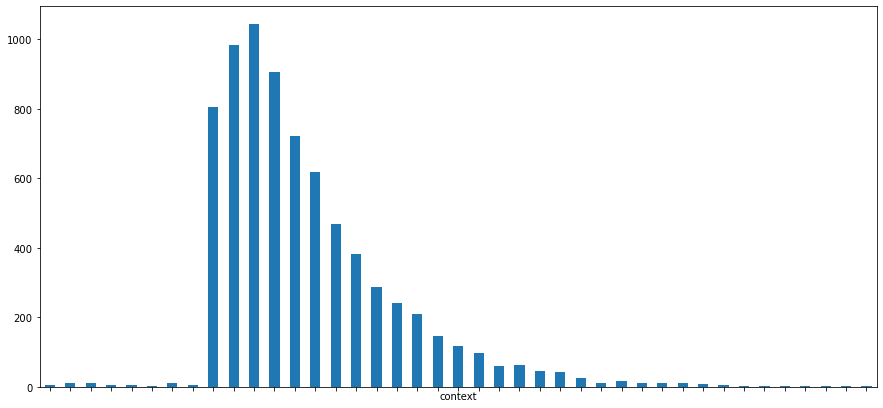

In [203]:
# distribution of number of context sentences
plot = num_of_context_sentences.plot(kind = 'bar', figsize=(15, 7))
plt.xticks(rotation=0)                                    # show label text horizontally
plt.setp(plot.axes.get_xticklabels(), visible=False)      # hide all labels
plt.setp(plot.axes.get_xticklabels()[::5], visible=True)  # set every 5 labels visible
plt.show() 

#### answer

In [204]:
dev_reduced_context_df.answer.str.split(' ').str.len().describe()  # statistic of number of words in the answer

count    7405.000000
mean        2.360837
std         1.659080
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        28.000000
Name: answer, dtype: float64

In [205]:
dev_reduced_context_df['normalized_answer_in_reduced_context'] = dev_reduced_context_df.apply(lambda row:  findWord(row['answer'], row['context']) == True , axis = 1)

In [206]:
dev_reduced_context_df.normalized_answer_in_reduced_context.describe()

count     7405
unique       2
top       True
freq      4419
Name: normalized_answer_in_reduced_context, dtype: object

4419 questions' answer in the context, 7405-4419 = 2986 questions' answer are not in the reduced context

In [207]:
dev_reduced_context_df.loc[(dev_reduced_context_df['normalized_answer_in_reduced_context'] == True) | (dev_reduced_context_df['answer'] == 'yes') | (dev_reduced_context_df['answer'] == 'no')].shape[0]

4658

In [208]:
dev_reduced_context_df.loc[(dev_reduced_context_df['normalized_answer_in_reduced_context'] == False) & (dev_reduced_context_df['answer'] != 'yes') & (dev_reduced_context_df['answer'] != 'no') & (dev_reduced_context_df['answer'] != '')].shape[0]

2745

#### supporting facts

In [209]:
dev_joint_df = dev_question_df.join(dev_reduced_context_df, rsuffix='_reduced_context')
dev_joint_df

_id                           answer  \
0     5a8b57f25542995d1e6f1371                              yes   
1     5a8c7595554299585d9e36b6                chief of protocol   
2     5a85ea095542994775f606a8                        animorphs   
3     5adbf0a255429947ff17385a                               no   
4     5a8e3ea95542995a26add48d  greenwich village new york city   
...                        ...                              ...   
7400  5ab92307554299753720f72d                    yasir hussain   
7401  5abba3b1554299642a094aed                               no   
7402  5a8173fa554299260e20a28e                              yes   
7403  5a8caf1d554299585d9e3720                              yes   
7404  5ac132a755429964131be17c            norwood massachusetts   

                                                                                                                                                     question  \
0                                                                                                  Were Scott Derrickson and Ed Wood of the same nationality?   
1                                                      What government position was held by the woman who portrayed Corliss Archer in the film Kiss and Tell?   
2     What science fantasy young adult series, told in first person, has a set of companion books narrating the stories of enslaved worlds and alien species?   
3                                                                             Are the Laleli Mosque and Esma Sultan Mansion located in the same neighborhood?   
4                                                                         The director of the romantic comedy "Big Stone Gap" is based in what New York city?   
...                                                                                                                                                       ...   
7400                                   What Pakistani actor and writer from Islamabad helped write for the 2012 Pakistani comedy drama sitcom, "Coke Kahani"?   
7401                                                                              Are both Volvic and Canfield's Diet Chocolate Fudge natural spring waters ?   
7402                                                    Are Billy and Barak both breeds of scenthound? (Barak is also known as a Bosnian Coarse-haired Hound)   
7403                                                   Were both of the following rock groups formed in California: Dig and Thinking Fellers Union Local 282?   
7404                                                          Blackfin is a family of processors developed by the company that is headquartered in what city?   

                                                                                                                      supporting_facts  \
0                                                                                                [[Scott Derrickson, 0], [Ed Wood, 0]]   
1                                                           [[Kiss and Tell (1945 film), 0], [Shirley Temple, 0], [Shirley Temple, 1]]   
2     [[The Hork-Bajir Chronicles, 0], [The Hork-Bajir Chronicles, 1], [The Hork-Bajir Chronicles, 2], [Animorphs, 0], [Animorphs, 1]]   
3                                                                                       [[Laleli Mosque, 0], [Esma Sultan Mansion, 0]]   
4                                                                                   [[Big Stone Gap (film), 0], [Adriana Trigiani, 0]]   
...                                                                                                                                ...   
7400                                                                          [[Coke Kahani, 0], [Coke Kahani, 1], [Yasir Hussain, 0]]   
7401                                                               [[Volvic (mineral water), 1], [Canfield's Diet Chocolate Fudge, 0]]   
7402                                           

In [210]:
dev_joint_df['sp_in_reduced_context'] = dev_joint_df.apply(lambda row: [ f in row['context_reduced_context'] for f in row['supporting_fact_text']], axis = 1)
dev_joint_df['sp_in_reduced_context']

0                             [True, True]
1                    [False, False, False]
2       [False, False, True, False, False]
3                            [True, False]
4                           [False, False]
                       ...                
7400                  [False, True, False]
7401                          [True, True]
7402                          [True, True]
7403                         [False, True]
7404                         [True, False]
Name: sp_in_reduced_context, Length: 7405, dtype: object

In [211]:
# how many supporting facts contained in the reduced context, that is, the count of 'True' / count of sp
dev_joint_df['sp_in_reduced_context_ratio'] = dev_joint_df['sp_in_reduced_context'].map(lambda x: sum(x) / len(x)) 
dev_joint_df['sp_in_reduced_context_ratio']

0       1.000000
1       0.000000
2       0.200000
3       0.500000
4       0.000000
          ...   
7400    0.333333
7401    1.000000
7402    1.000000
7403    0.500000
7404    0.500000
Name: sp_in_reduced_context_ratio, Length: 7405, dtype: float64

In [212]:
dev_joint_df['sp_in_reduced_context_ratio'].describe()

count    7405.000000
mean        0.487494
std         0.354765
min         0.000000
25%         0.200000
50%         0.500000
75%         0.666667
max         1.000000
Name: sp_in_reduced_context_ratio, dtype: float64

In [213]:
# Distribution of number of supporting facts in reduced_context
dev_joint_df['num_of_sp_in_reduced_context'] = dev_joint_df['sp_in_reduced_context'].map(lambda x: sum(x))
grouped = dev_joint_df.groupby(['num_of_sp_in_reduced_context'])
num_of_sp_in_reduced_context_counts = grouped.size()  # count of each 
num_of_sp_in_reduced_context_counts

num_of_sp_in_reduced_context
0    1834
1    2936
2    2207
3     373
4      51
5       4
dtype: int64

In [214]:
# reduced_context contains the answer, even though does not contain any supporting fact
dev_joint_df.loc[(dev_joint_df.num_of_sp_in_reduced_context == 0) & (dev_joint_df.normalized_answer_in_reduced_context == True)].shape[0]

591

In [215]:
dev_joint_df.loc[(dev_joint_df.num_of_sp_in_reduced_context == 0) & (dev_joint_df.normalized_answer_in_reduced_context == True)].head(3)

_id           answer  \
28  5a828c8355429966c78a6a50   henry j kaiser   
29  5a8a3e745542996c9b8d5e70  arena of khazan   
37  5a80721b554299485f5985ef     world war ii   

                                                                                                                                question  \
28  Kaiser Ventures corporation was founded by an American industrialist who became known as the father of modern American shipbuilding?   
29                                         What is the name for the adventure in "Tunnels and Trolls", a game designed by Ken St. Andre?   
37                               The Livesey Hal War Memorial commemorates the fallen of which war, that had over 60 million casualties?   

                                                      supporting_facts  \
28  [[Kaiser Ventures, 0], [Kaiser Ventures, 1], [Henry J. Kaiser, 0]]   
29                   [[Arena of Khazan, 0], [Tunnels &amp; Trolls, 0]]   
37      [[Livesey Hall War Memorial, 0], [World War II casualties, 1]]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [216]:
dev_joint_df['sp_text_reduced_context'] = dev_joint_df.apply(lambda row: [ f for f in row['supporting_fact_text'] if f in row['context_reduced_context'] ], axis = 1)
dev_joint_df['sp_text_reduced_context']

0                                                                                            [scott derrickson born july 16 1966 is american director screenwriter and producer, edward davis wood jr october 10 1924 – december 10 1978 was american filmmaker actor writer producer and director]
1                                                                                                                                                                                                                                                                                                []
2                                                      [book is introduced by tobias who flies to valley of free horkbajir where jara hamee tells him story of how yeerks enslaved horkbajir and how aldrea andalite and her companion dak hamee horkbajir tried to save their world from invasion]
3                                                                                                                           

In [217]:
dev_joint_df['normalized_answer_in_reduced_sp_text'] = dev_joint_df.apply(lambda row: any([ findWord(row['answer'], f) == True for f in row['sp_text_reduced_context']]), axis = 1)
dev_joint_df['normalized_answer_in_reduced_sp_text']

0       False
1       False
2       False
3       False
4       False
        ...  
7400     True
7401     True
7402    False
7403    False
7404    False
Name: normalized_answer_in_reduced_sp_text, Length: 7405, dtype: bool

In [218]:
dev_joint_df.normalized_answer_in_reduced_sp_text.describe()

count      7405
unique        2
top       False
freq       4236
Name: normalized_answer_in_reduced_sp_text, dtype: object

4236 questions' answer in the context, 7405-4236 = 3169 questions' answer are not in the reduced context

In [219]:
dev_joint_df.loc[(dev_joint_df['normalized_answer_in_reduced_sp_text'] == False) & (dev_joint_df['answer'] != 'yes') & (dev_joint_df['answer'] != 'no') & (dev_joint_df['answer'] != '')].shape[0]

3881

In [220]:
# reduced_context contain the answer, but the sp in reduced context does not contain the answer
dev_joint_df.loc[(dev_joint_df.normalized_answer_in_reduced_context == True) & (dev_joint_df.normalized_answer_in_reduced_sp_text == False) ].shape[0]

1250

In [221]:
dev_joint_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   _id                                   7405 non-null   object 
 1   answer                                7405 non-null   object 
 2   question                              7405 non-null   object 
 3   supporting_facts                      7405 non-null   object 
 4   context                               7405 non-null   object 
 5   type                                  7405 non-null   object 
 6   level                                 7405 non-null   object 
 7   context_flattened                     7405 non-null   object 
 8   context_joint                         7405 non-null   object 
 9   normalized_answer_in_context          7405 non-null   bool   
 10  invalid_supporting_facts_ids          7405 non-null   bool   
 11  supporting_fact_t

In [222]:
# save file contains only the questions has answer in the reduced_context

hotpot_reduced_dev_df = dev_joint_df.loc[(dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no') , ['supporting_facts', 'context', 'answer', '_id', 'question']]
hotpot_reduced_dev_df

#hotpot_reduced_dev_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/hotpot_reduced_dev_distractor.json", orient="records") 

In [223]:
dev_joint_df['raw_reduced_context'] = dev_joint_df.context_reduced_context.str.split(pat='<t>').map(convert_to_raw_context)

In [224]:
dev_joint_df.raw_reduced_context[0]

[['ed wood film',
  [' ed wood is 1994 american biographical period comedydrama film directed and produced by tim burton and starring johnny depp as cult filmmaker ed wood ',
   ' film concerns period in woods life when he made his bestknown films as well as his relationship with actor bela lugosi played by martin landau ']],
 ['scott derrickson',
  [' scott derrickson born july 16 1966 is american director screenwriter and producer ',
   ' he lives in los angeles california ']],
 ['ed wood',
  [' edward davis wood jr october 10 1924 – december 10 1978 was american filmmaker actor writer producer and director ']],
 ['deliver us from evil 2014 film',
  [' film is officially based on 2001 nonfiction book entitled beware night by ralph sarchie and lisa collier cool and its marketing campaign highlighted that it was inspired by actual accounts ']],
 ['sinister film',
  [' it stars ethan hawke as fictional truecrime writer ellison oswalt who discovers box of home movies in his attic that pu

In [225]:
# save file contains only the questions with reduced_context has answer in the reduced_context

hotpot_dev_reduced_context_df = dev_joint_df.loc[(dev_joint_df['normalized_answer_in_reduced_context'] == True) | (dev_joint_df['answer'] == 'yes') | (dev_joint_df['answer'] == 'no') , ['supporting_facts', 'raw_reduced_context', 'answer', '_id', 'question']]
hotpot_dev_reduced_context_df.rename(columns={"raw_reduced_context": "context"})

#hotpot_dev_reduced_context_df.to_json("/xdisk/msurdeanu/fanluo/hotpotQA/hotpot_reduced_dev_distractor_reduced_context.json", orient="records") 

In [ ]:
plan:
    - submit to acl Feb 1rd  
        - longformer results
        - debug and fix
        - error analysis 
        - rest questions not in 64245 ()
        - writing paper (2 weeks)
- send to Mihai
- send to comittee

In [ ]:
proposal: (10~12 pages)
    - intro and motivation
       - reasoning system without logic, approx instead, roubst with graph-based method
    - related works 
        -  qa 
        - KG based
        - multi-hop reasoning   
        - graph-based
        
    - pre results (analysis)
    - plan for the dissertation
       - refer to mithun's proposal under github's paper
        - 3 works
        

In [ ]:
from numpy import loadtxt
reduced_context_ratios = loadtxt("graph_reduced_context_ratios.txt", delimiter=",")
reduced_context_ratios_df = pd.DataFrame(reduced_context_ratios)

In [ ]:
reduced_context_ratios_df.head(3)

In [ ]:
reduced_context_ratios_df.describe()

In [ ]:
non_zero_df = reduced_context_ratios_df[0] ! = 0

## Ranking

#### Sentences Similarity

##### sklearn

###### TF-IDF 

##### glove embedding

##### flair embedding

##### transformer embedding

#### Longformer

In [ ]:
>>> from transformers import LongformerTokenizer, LongformerForQuestionAnswering
>>> import torch

>>> tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-large-4096-finetuned-triviaqa")
>>> model = LongformerForQuestionAnswering.from_pretrained("allenai/longformer-large-4096-finetuned-triviaqa")

In [ ]:
#!python -m pip install flair
from typing import List
from torch.utils.data import Dataset
import torch
from flair.data import Sentence, Corpus
from flair.embeddings import DocumentRNNEmbeddings, BertEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
import time
import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix

In [ ]:
import nltk
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
